In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch 
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('hvac-data-cleaned.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,on_off,damper,active_energy,co2_1,ambient_humidity,active_power,power_generated,high_pressure_1,high_pressure_2,low_pressure_1,low_pressure_2,high_pressure_3,low_pressure_3,outside_temp,outlet_temp,inlet_temp,summer_SP_temp,winter_SP_temp,ambient_temp
timestamp,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,0,0,762617.8,975,35,0.51,4,15.09,15,15.27,15.1,15.2,15.2,23.9,24.3,22.9,22.5,18,23.4
2022-06-01 00:05:00,0,0,\N,977,35,0.51,\N,15.03,14.9,15.21,15,15.2,15.1,23.8,24.3,22.8,22.5,18,23.3
2022-06-01 00:10:00,0,0,\N,975,35,0.51,\N,15.03,14.8,15.15,15,15.1,15.1,23.6,24.2,22.6,22.5,18,23.4
2022-06-01 00:15:00,0,0,762617.99,975,35,0.51,4,14.96,14.8,15.15,14.9,15.1,15,23.6,24,22.4,22.5,18,23.3
2022-06-01 00:20:00,0,0,\N,975,35,0.51,\N,14.9,14.7,15.09,14.9,15,14.9,23.4,24,22.3,22.5,18,23.3


In [3]:
print("=== Data Overview ===")
print(f"Time range: {df.index.min()} to {df.index.max()}")
print(f"Total records: {len(df)}")
print(f"Data frequency: {pd.infer_freq(df.index)}")
print("data types\n")
print(df.dtypes)

=== Data Overview ===
Time range: 2022-06-01 00:00:00 to 2022-08-30 23:55:00
Total records: 25632
Data frequency: None
data types

on_off              object
damper              object
active_energy       object
co2_1               object
ambient_humidity    object
active_power        object
power_generated     object
high_pressure_1     object
high_pressure_2     object
low_pressure_1      object
low_pressure_2      object
high_pressure_3     object
low_pressure_3      object
outside_temp        object
outlet_temp         object
inlet_temp          object
summer_SP_temp      object
winter_SP_temp      object
ambient_temp        object
dtype: object


In [4]:
for col in df.columns:
    if df[col].dtype == 'object': 
        if (df[col] == r'\N').any():
            print(f"Warning: '\\N' found in column '{col}' after initial load. Replacing...")
            df[col] = df[col].replace(r'\N', np.nan)


In [5]:
df.head()

,on_off,damper,active_energy,co2_1,ambient_humidity,active_power,power_generated,high_pressure_1,high_pressure_2,low_pressure_1,low_pressure_2,high_pressure_3,low_pressure_3,outside_temp,outlet_temp,inlet_temp,summer_SP_temp,winter_SP_temp,ambient_temp
timestamp,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,0,0,762617.8,975,35,0.51,4,15.09,15,15.27,15.1,15.2,15.2,23.9,24.3,22.9,22.5,18,23.4
2022-06-01 00:05:00,0,0,NaN,977,35,0.51,NaN,15.03,14.9,15.21,15,15.2,15.1,23.8,24.3,22.8,22.5,18,23.3
2022-06-01 00:10:00,0,0,NaN,975,35,0.51,NaN,15.03,14.8,15.15,15,15.1,15.1,23.6,24.2,22.6,22.5,18,23.4
2022-06-01 00:15:00,0,0,762617.99,975,35,0.51,4,14.96,14.8,15.15,14.9,15.1,15,23.6,24,22.4,22.5,18,23.3
2022-06-01 00:20:00,0,0,NaN,975,35,0.51,NaN,14.9,14.7,15.09,14.9,15,14.9,23.4,24,22.3,22.5,18,23.3


In [6]:
for col in df.columns:
    if df[col].dtype == 'object': 
       print(f"column {col} has {df[col].isna().sum()} nan values")


column on_off has 75 nan values
column damper has 77 nan values
column active_energy has 17114 nan values
column co2_1 has 78 nan values
column ambient_humidity has 336 nan values
column active_power has 72 nan values
column power_generated has 17088 nan values
column high_pressure_1 has 79 nan values
column high_pressure_2 has 76 nan values
column low_pressure_1 has 79 nan values
column low_pressure_2 has 76 nan values
column high_pressure_3 has 76 nan values
column low_pressure_3 has 76 nan values
column outside_temp has 77 nan values
column outlet_temp has 76 nan values
column inlet_temp has 75 nan values
column summer_SP_temp has 76 nan values
column winter_SP_temp has 77 nan values
column ambient_temp has 142 nan values


In [7]:
df['active_energy'] = pd.to_numeric(df['active_energy'], errors='coerce')
df['active_energy'] = df['active_energy'].interpolate(method='linear', limit_direction='both')
df['power_generated'] = pd.to_numeric(df['power_generated'], errors='coerce')

df['power_generated'] = df['power_generated'].fillna(df['power_generated'].mean())

In [8]:
df.head()

,on_off,damper,active_energy,co2_1,ambient_humidity,active_power,power_generated,high_pressure_1,high_pressure_2,low_pressure_1,low_pressure_2,high_pressure_3,low_pressure_3,outside_temp,outlet_temp,inlet_temp,summer_SP_temp,winter_SP_temp,ambient_temp
timestamp,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,0,0,762617.800000,975,35,0.51,4.000000,15.09,15,15.27,15.1,15.2,15.2,23.9,24.3,22.9,22.5,18,23.4
2022-06-01 00:05:00,0,0,762617.863333,977,35,0.51,24.113179,15.03,14.9,15.21,15,15.2,15.1,23.8,24.3,22.8,22.5,18,23.3
2022-06-01 00:10:00,0,0,762617.926667,975,35,0.51,24.113179,15.03,14.8,15.15,15,15.1,15.1,23.6,24.2,22.6,22.5,18,23.4
2022-06-01 00:15:00,0,0,762617.990000,975,35,0.51,4.000000,14.96,14.8,15.15,14.9,15.1,15,23.6,24,22.4,22.5,18,23.3
2022-06-01 00:20:00,0,0,762618.060000,975,35,0.51,24.113179,14.9,14.7,15.09,14.9,15,14.9,23.4,24,22.3,22.5,18,23.3


In [9]:
df['on_off'] = df['on_off'].fillna(method='ffill')
df['damper'] = df['damper'].fillna(df['damper'].mode()[0])

/tmp/ipykernel_9407/2348853756.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['on_off'] = df['on_off'].fillna(method='ffill')


In [10]:
def clean_data(df, numerical_cols):
    for col in numerical_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    for col in numerical_cols:
        df[col] = df[col].interpolate(method='linear', limit_direction='both')
        
        df[col] = df[col].fillna(df[col].rolling(24*12, min_periods=1).mean())  # 24-hour window
        
        df[col] = df[col].fillna(df[col].mean())
    
    print("\n=== After Cleaning ===")
    for col in numerical_cols:
        nan_count = df[col].isna().sum()
        if nan_count > 0:
            print(f"Warning: {col} still has {nan_count} NaN values")
        else:
            print(f"{col}: Clean (0 NaN)")
    
    return df

numerical_cols = ['co2_1', 'ambient_humidity', 'active_power', 
                 'high_pressure_1', 'high_pressure_2', 'low_pressure_1', 
                 'low_pressure_2', 'high_pressure_3', 'low_pressure_3',
                 'outside_temp', 'outlet_temp', 'inlet_temp',
                 'summer_SP_temp', 'winter_SP_temp', 'ambient_temp']

df = clean_data(df, numerical_cols)


=== After Cleaning ===
co2_1: Clean (0 NaN)
ambient_humidity: Clean (0 NaN)
active_power: Clean (0 NaN)
high_pressure_1: Clean (0 NaN)
high_pressure_2: Clean (0 NaN)
low_pressure_1: Clean (0 NaN)
low_pressure_2: Clean (0 NaN)
high_pressure_3: Clean (0 NaN)
low_pressure_3: Clean (0 NaN)
outside_temp: Clean (0 NaN)
outlet_temp: Clean (0 NaN)
inlet_temp: Clean (0 NaN)
summer_SP_temp: Clean (0 NaN)
winter_SP_temp: Clean (0 NaN)
ambient_temp: Clean (0 NaN)


In [11]:

for col in df.columns:
    if df[col].dtype == 'object': 
       print(f"column {col} has {df[col].isna().sum()} nan values")


column on_off has 0 nan values
column damper has 0 nan values


In [12]:
scaler = MinMaxScaler()
numerical_cols = ['active_energy', 'active_power', 'co2_1', 'ambient_humidity', 
                  'high_pressure_1', 'high_pressure_2', 'low_pressure_1', 'low_pressure_2',
                  'high_pressure_3', 'low_pressure_3', 'outside_temp', 'outlet_temp', 'inlet_temp']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [13]:
df.head()

,on_off,damper,active_energy,co2_1,ambient_humidity,active_power,power_generated,high_pressure_1,high_pressure_2,low_pressure_1,low_pressure_2,high_pressure_3,low_pressure_3,outside_temp,outlet_temp,inlet_temp,summer_SP_temp,winter_SP_temp,ambient_temp
timestamp,,,,,,,,,,,,,,,,,,,
2022-06-01 00:00:00,0,0,0.000000,0.037951,0.564516,0.000697,4.000000,0.202243,0.177778,0.461669,0.461988,0.279720,0.284722,0.279006,0.400000,0.214464,22.5,18.0,23.4
2022-06-01 00:05:00,0,0,0.000001,0.041746,0.564516,0.000697,24.113179,0.199751,0.173333,0.458286,0.456140,0.279720,0.277778,0.276243,0.400000,0.211970,22.5,18.0,23.3
2022-06-01 00:10:00,0,0,0.000002,0.037951,0.564516,0.000697,24.113179,0.199751,0.168889,0.454904,0.456140,0.272727,0.277778,0.270718,0.397674,0.206983,22.5,18.0,23.4
2022-06-01 00:15:00,0,0,0.000003,0.037951,0.564516,0.000697,4.000000,0.196844,0.168889,0.454904,0.450292,0.272727,0.270833,0.270718,0.393023,0.201995,22.5,18.0,23.3
2022-06-01 00:20:00,0,0,0.000004,0.037951,0.564516,0.000697,24.113179,0.194352,0.164444,0.451522,0.450292,0.265734,0.263889,0.265193,0.393023,0.199501,22.5,18.0,23.3


In [14]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 12 
X = create_sequences(df[numerical_cols].values, seq_length)

In [15]:
X = torch.tensor(X, dtype=torch.float32)

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [16]:
dataset = TimeSeriesDataset(X)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_length, n_features, hidden_dim=64, latent_dim=32):
        super(LSTMAutoencoder, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        
        self.encoder_lstm1 = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(hidden_dim, latent_dim, batch_first=True)
        
        self.decoder_lstm1 = nn.LSTM(latent_dim, latent_dim, batch_first=True)
        self.decoder_lstm2 = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.decoder_dense = nn.Linear(hidden_dim, n_features)

    def forward(self, x):
        _, (hidden, _) = self.encoder_lstm1(x)
        _, (hidden, _) = self.encoder_lstm2(hidden)
        
        latent = hidden.repeat(self.seq_length, 1, 1).permute(1, 0, 2)
        
        x, _ = self.decoder_lstm1(latent)
        x, _ = self.decoder_lstm2(x)
        x = self.decoder_dense(x)
        return x

In [18]:
model = LSTMAutoencoder(seq_length=seq_length, n_features=len(numerical_cols))

print(f"Model initialized: {model}")

print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized: LSTMAutoencoder(
  (encoder_lstm1): LSTM(13, 64, batch_first=True)
  (encoder_lstm2): LSTM(64, 32, batch_first=True)
  (decoder_lstm1): LSTM(32, 32, batch_first=True)
  (decoder_lstm2): LSTM(32, 64, batch_first=True)
  (decoder_dense): Linear(in_features=64, out_features=13, bias=True)
)
Number of parameters: 67149


Using device: cuda


/home/pikubha/xempla/ai-intern/hvac/venv/lib64/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 12, 13])) that is different to the input size (torch.Size([1, 12, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pikubha/xempla/ai-intern/hvac/venv/lib64/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 12, 13])) that is different to the input size (torch.Size([1, 12, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pikubha/xempla/ai-intern/hvac/venv/lib64/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 12, 13])) that is different to the input size (torch.Size([1, 12, 13]))

Epoch 1/60 - Train Loss: 0.0475, Val Loss: 0.0449, LR: 0.001000
Epoch 2/60 - Train Loss: 0.0445, Val Loss: 0.0448, LR: 0.001000
Epoch 3/60 - Train Loss: 0.0445, Val Loss: 0.0448, LR: 0.001000
Epoch 4/60 - Train Loss: 0.0445, Val Loss: 0.0449, LR: 0.001000
Epoch 5/60 - Train Loss: 0.0444, Val Loss: 0.0451, LR: 0.001000
Epoch 6/60 - Train Loss: 0.0444, Val Loss: 0.0448, LR: 0.001000
Epoch 7/60 - Train Loss: 0.0443, Val Loss: 0.0447, LR: 0.001000
Epoch 8/60 - Train Loss: 0.0442, Val Loss: 0.0445, LR: 0.001000
Epoch 9/60 - Train Loss: 0.0439, Val Loss: 0.0443, LR: 0.001000
Epoch 10/60 - Train Loss: 0.0438, Val Loss: 0.0446, LR: 0.001000
Epoch 11/60 - Train Loss: 0.0438, Val Loss: 0.0444, LR: 0.001000
Epoch 12/60 - Train Loss: 0.0438, Val Loss: 0.0442, LR: 0.001000
Epoch 13/60 - Train Loss: 0.0438, Val Loss: 0.0442, LR: 0.001000
Epoch 14/60 - Train Loss: 0.0437, Val Loss: 0.0442, LR: 0.001000
Epoch 15/60 - Train Loss: 0.0438, Val Loss: 0.0442, LR: 0.001000
Epoch 16/60 - Train Loss: 0.0437, 

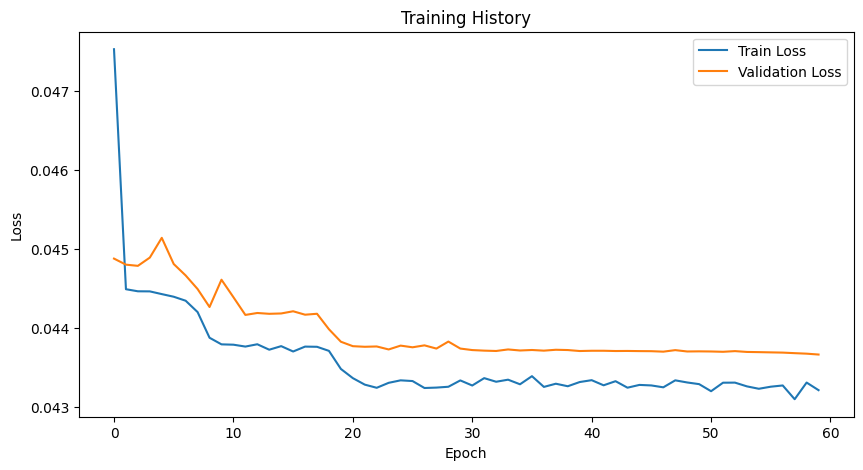

In [19]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//2, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    best_model = None
    early_stop_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:              
            batch = batch.to(device)
            
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)  
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:  
                batch = batch.to(device)
                output = model(batch)
                val_loss += criterion(output, batch).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()
    
    return model

trained_model = train_model(model, train_loader, val_loader, epochs=60, lr=0.001, patience=10)


Detected 118 anomalies (threshold: 0.1325)


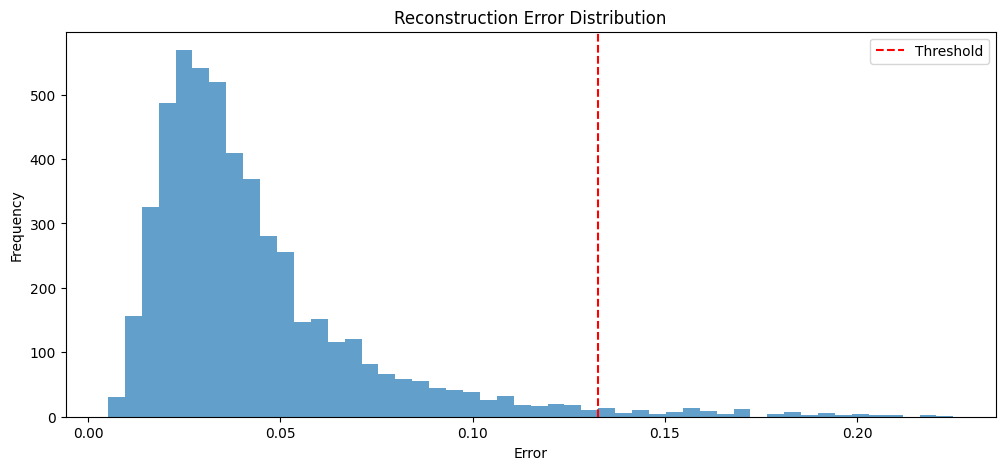

In [20]:
def detect_anomalies(model, data_loader, threshold_std=3):
    device = next(model.parameters()).device
    model.eval()
    
    errors = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            outputs = model(batch)
            error = torch.mean((outputs - batch)**2, dim=(1,2))
            errors.extend(error.cpu().numpy())
    
    errors = np.array(errors)
    threshold = errors.mean() + threshold_std * errors.std()
    
    anomalies = np.where(errors > threshold)[0]
    print(f"\nDetected {len(anomalies)} anomalies (threshold: {threshold:.4f})")
    
    # Plot anomaly distribution
    plt.figure(figsize=(12, 5))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return anomalies, threshold

# Detect anomalies
anomalies, threshold = detect_anomalies(trained_model, val_loader)

In [21]:
import json
import os
import pickle

def save_model_for_inference(model, scaler, numerical_cols, seq_length, save_dir='saved_model'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, 'model_weights.pth')
    torch.save(model.state_dict(), model_path)
    
    scaler_path = os.path.join(save_dir, 'scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    metadata = {
        'numerical_cols': numerical_cols,
        'seq_length': seq_length,
        'input_shape': (seq_length, len(numerical_cols))
    }
    with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
        json.dump(metadata, f)
    
    print(f"Model saved to {save_dir}")
    
save_model_for_inference(trained_model, scaler, numerical_cols, seq_length)

Model saved to saved_model


Calculated Anomaly Threshold (99.5th percentile of training errors): 0.1879


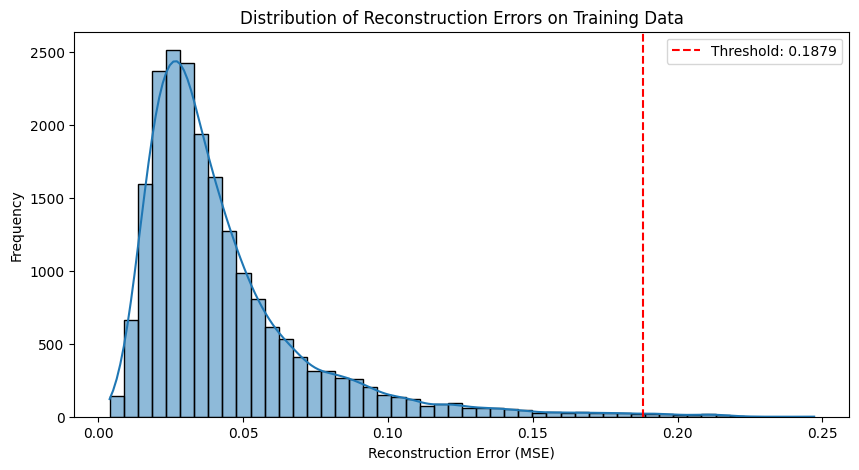

Number of anomalies detected in validation set: 23
Percentage of anomalies detected: 0.45%


/home/pikubha/xempla/ai-intern/hvac/venv/lib64/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 12, 13])) that is different to the input size (torch.Size([1, 12, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pikubha/xempla/ai-intern/hvac/venv/lib64/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 12, 13])) that is different to the input size (torch.Size([1, 12, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [22]:
def get_reconstruction_errors(model, dataloader, device):
    errors = []
    model.eval()
    criterion = nn.MSELoss(reduction='none') # Keep individual errors
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            errors.extend(loss.mean(dim=[1, 2]).cpu().numpy())
    return np.array(errors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_errors = get_reconstruction_errors(trained_model, train_loader, device)

threshold = np.percentile(train_errors, 99.5) # You can adjust this percentile
print(f"Calculated Anomaly Threshold (99.5th percentile of training errors): {threshold:.4f}")

plt.figure(figsize=(10, 5))
sns.histplot(train_errors, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('Distribution of Reconstruction Errors on Training Data')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


val_errors = get_reconstruction_errors(trained_model, val_loader, device)

anomalies = val_errors > threshold
print(f"Number of anomalies detected in validation set: {np.sum(anomalies)}")
print(f"Percentage of anomalies detected: {np.sum(anomalies) / len(val_errors) * 100:.2f}%")


In [23]:
def detect_anomalies(model, data_loader, threshold_percentile=95):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    reconstruction_errors = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            output = model(batch)
            mse = torch.mean((output - batch) ** 2, dim=[1, 2]).cpu().numpy()
            reconstruction_errors.extend(mse)
    
    reconstruction_errors = np.array(reconstruction_errors)
    
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    anomalies = reconstruction_errors > threshold
    
    print(f"Anomaly threshold (MSE): {threshold:.4f}")
    print(f"Number of anomalies detected: {np.sum(anomalies)}")

    print(f"reconstruction error: {reconstruction_errors}")
    
    return reconstruction_errors, anomalies, threshold

reconstruction_errors, anomalies, threshold = detect_anomalies(trained_model, val_loader)

Anomaly threshold (MSE): 0.1020
Number of anomalies detected: 257
reconstruction error: [0.04522885 0.0300384  0.02359068 ... 0.00721504 0.03019094 0.04343061]


In [24]:
def generate_alerts(df, anomalies, reconstruction_errors, numerical_cols, seq_length):
    anomaly_indices = np.where(anomalies)[0]
    anomaly_times = df.index[seq_length:][anomaly_indices] 
    alert_df = pd.DataFrame({
        'timestamp': anomaly_times,
        'reconstruction_error': reconstruction_errors[anomaly_indices]
    })
    
    alert_df['severity'] = pd.qcut(
        alert_df['reconstruction_error'], 
        q=3, 
        labels=['Low', 'Medium', 'High']
    )
    
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    contributing_features = []
    for idx in anomaly_indices:
        seq = torch.tensor(
            df[numerical_cols].values[idx:idx+seq_length], 
            dtype=torch.float32
        ).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(seq)
            feature_errors = torch.mean((output - seq) ** 2, dim=[0, 1]).cpu().numpy()
        top_feature_idx = np.argmax(feature_errors)
        contributing_features.append(numerical_cols[top_feature_idx])
    
    alert_df['contributing_feature'] = contributing_features[:len(anomaly_times)]
    
    alert_df.to_csv('anomaly_alerts.csv', index=False)
    print("Alerts saved to 'anomaly_alerts.csv'")
    return alert_df

alert_df = generate_alerts(df, anomalies, reconstruction_errors, numerical_cols, seq_length)

Alerts saved to 'anomaly_alerts.csv'


In [25]:
def create_maintenance_schedule(alert_df):
    alert_df['date'] = alert_df['timestamp'].dt.date
    daily_schedule = alert_df.groupby('date').agg({
        'severity': lambda x: x.value_counts().to_dict(),
        'contributing_feature': lambda x: ', '.join(x.unique()),
        'reconstruction_error': 'mean'
    }).reset_index()
    
    daily_schedule['recommended_action'] = daily_schedule['severity'].apply(
        lambda x: 'Immediate Inspection' if 'High' in x else 'Schedule Routine Check' if 'Medium' in x else 'Monitor'
    )
    
    daily_schedule.to_csv('maintenance_schedule.csv', index=False)
    print("Maintenance schedule saved to 'maintenance_schedule.csv'")
    return daily_schedule

maintenance_schedule = create_maintenance_schedule(alert_df)

Maintenance schedule saved to 'maintenance_schedule.csv'


In [26]:
def integrate_with_fdd(alert_df):
    fdd_input = alert_df[['timestamp', 'severity', 'contributing_feature', 'reconstruction_error']]
    fdd_input['diagnostic_trigger'] = fdd_input['severity'].apply(
        lambda x: 'Trigger Diagnostic' if x in ['Medium', 'High'] else 'No Action'
    )
    
    fdd_input.to_csv('fdd_input.csv', index=False)
    print("FDD integration file saved to 'fdd_input.csv'")
    return fdd_input

fdd_input = integrate_with_fdd(alert_df)

FDD integration file saved to 'fdd_input.csv'


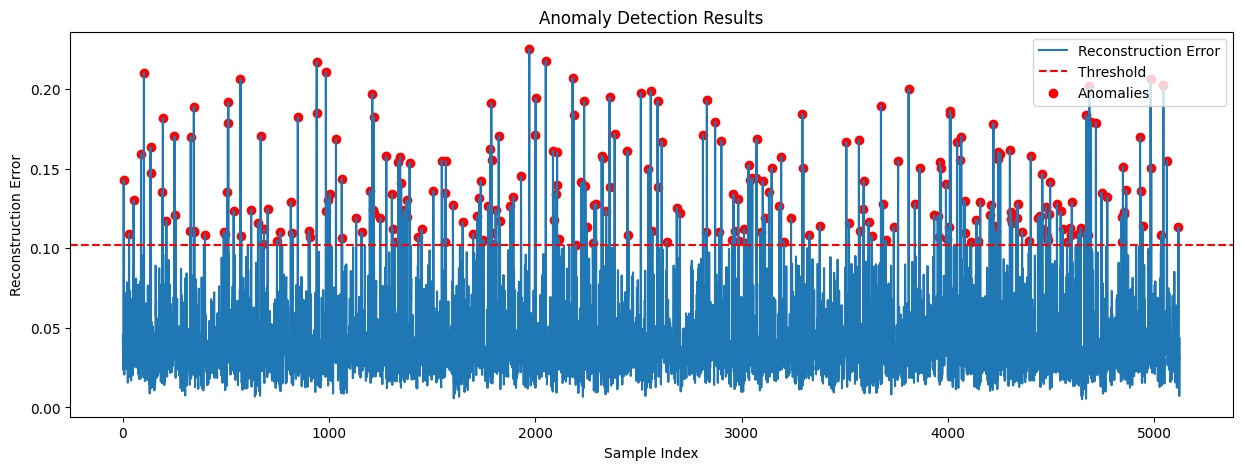

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_anomalies(df, reconstruction_errors, anomalies, threshold, numerical_cols):
    plt.figure(figsize=(15, 5))
    plt.plot(reconstruction_errors, label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='red', label='Anomalies')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error')
    plt.title('Anomaly Detection Results')
    plt.legend()
    plt.savefig('anomaly_plot.png')
    plt.show()
    
    # Plot contributing features for top anomalies
    # top_anomalies = alert_df.nlargest(100, 'reconstruction_error')
    # plt.figure(figsize=(10, 5))
    # sns.barplot(x='reconstruction_error', y='contributing_feature', hue='severity', data=top_anomalies)
    # plt.title('Top 5 Anomalies by Contributing Feature')
    # plt.savefig('contributing_features.png')
    # plt.show()

# Plot anomalies
plot_anomalies(df, reconstruction_errors, anomalies, threshold, numerical_cols)